In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.autograd import Variable
import math

In [2]:
def ExactSolution(x,y):
    # e^{-x}(x+y^3)
    return y**2*torch.sin(torch.pi*x)

In [3]:
def prepare_data(xmin,xmax,nx,ymin,ymax,ny,strip_bdry):
    x1 = torch.linspace(xmin,xmax,steps = nx)
    y1 = torch.linspace(ymin,ymax,steps = ny)
    if strip_bdry == True:
        grid_x, grid_y = torch.meshgrid(x1[1:nx-1],y1[1:ny-1])
    else:
        grid_x, grid_y = torch.meshgrid(x1,y1)
    xcol = torch.reshape(grid_x,(grid_x.numel(),1))
    ycol = torch.reshape(grid_y,(grid_y.numel(),1))
    data_matrix = torch.cat((xcol,ycol),1)
    return grid_x, grid_y, data_matrix

C:\Users\RyanPC\anaconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[0.0500, 0.0500],
        [0.0500, 0.1000],
        [0.0500, 0.1500],
        [0.0500, 0.2000],
        [0.0500, 0.2500],
        [0.0500, 0.3000],
        [0.0500, 0.3500],
        [0.0500, 0.4000],
        [0.0500, 0.4500],
        [0.0500, 0.5000],
        [0.0500, 0.5500],
        [0.0500, 0.6000],
        [0.0500, 0.6500],
        [0.0500, 0.7000],
        [0.0500, 0.7500],
        [0.0500, 0.8000],
        [0.0500, 0.8500],
        [0.0500, 0.9000],
        [0.0500, 0.9500],
        [0.1000, 0.0500],
        [0.1000, 0.1000],
        [0.1000, 0.1500],
        [0.1000, 0.2000],
        [0.1000, 0.2500],
        [0.1000, 0.3000],
        [0.1000, 0.3500],
        [0.1000, 0.4000],
        [0.1000, 0.4500],
        [0.1000, 0.5000],
        [0.1000, 0.5500],
        [0.1000, 0.6000],
        [0.1000, 0.6500],
        [0.1000, 0.7000],
        [0.1000, 0.7500],
        [0.1000, 0.8000],
        [0.1000, 0.8500],
        [0.1000, 0.9000],
        [0.1000, 0.9500],
        [0.1

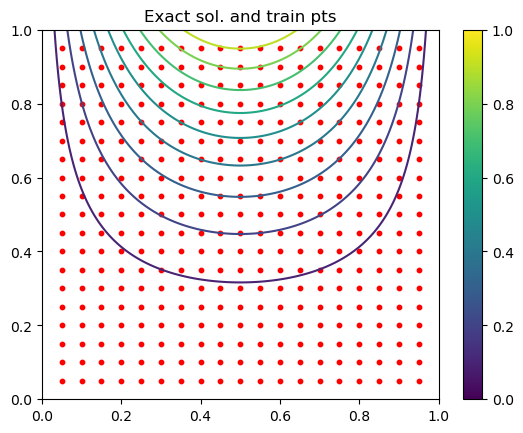

In [4]:
# define training points
npt1 = 21
strip_boundary = True
xtrain_grid, ytrain_grid, train_data = prepare_data(0.,1.,npt1,0.,1.,npt1,strip_boundary)

# define test points
npt2 = 100
strip_boundary = False
xtest_grid, ytest_grid, xytest = prepare_data(0.,1.,npt2,0.,1.,npt2,strip_boundary)

# find the exact solution at the test points
sol_exact = ExactSolution(xtest_grid,ytest_grid)
sol_exact_vector = torch.reshape(sol_exact,(torch.numel(sol_exact),1))
sol_min = torch.min(sol_exact_vector)
sol_max = torch.max(sol_exact_vector)

# plot the exact solution and the training points
plt.figure()
plt.contour(xtest_grid,ytest_grid,sol_exact,torch.arange(sol_min,sol_max,(sol_max-sol_min)*0.1))  
plt.scatter(train_data[:,0],train_data[:,1],s = 10, c = '#FF0000')
plt.colorbar()
plt.title("Exact sol. and train pts")

train_data.requires_grad_(True)

In [ ]:
# x = np.linspace(0,1,100)
# y = np.linspace(0,1,100)
# x_train, y_train = np.meshgrid(x,y)
# train_data = torch.tensor(np.hstack((x_train.ravel()[:,None],y_train.ravel()[:,None])),\
#                          dtype = torch.float32)
# train_data.requires_grad_(True)

In [ ]:
class NN(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # 1st hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size,out_size)
        
        
        
    def forward(self, xb):
        act = nn.Tanh()
#         act = torch.sigmoid()
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = torch.sigmoid(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    

def SolutionModel(x, y, model):
    '''
    Compute the approximate solution to the problem based on the known
    boundary conditions and the neural network approximation in the domain.

    Nx is the number of mesh points in the x direction, similarly for Ny.

    Arguments
    ---------
    x: input tensor of shape (Nx * Ny,)
    y: input tensor of shape (Nx * Ny,)
    model: an object extending torch.nn.Module

    Returns
    -------
    solution: output tensor of shape (Nx * Ny, 1)
    '''

    # create tensor of size (Nx * Ny, 1) of ones for top (x, 1) boundary 
    ones = torch.ones_like(y[:, None])
    ones.requires_grad = True

    # compute boundary term
    B = 2*y*torch.sin(torch.pi*x)

    # compute N(x,y;w)
    domain_input_data = torch.cat((x[:, None], y[:, None]), axis=1)
    N1 = model(domain_input_data)[:, 0]

    # compute N(x,1;w)
    boundary_input_data = torch.cat((x[:, None], ones), axis=1)
    N2 = model(boundary_input_data)[:, 0]

    # compute N_y(x,1;w)
    N3 = torch.autograd.grad(outputs=N2,
                             inputs=ones,
                             allow_unused=True,
                             grad_outputs=torch.ones_like(N2),
                             retain_graph=True,
                             create_graph=True)[0][:, 0]

    # compute domain term
    C = x*(1-x)*y*(N1-N2-N3)
    
    solution = B+C

    return(solution[:, None])


def Solution(x,y,NN):
    # u(x,y) = B(x,y) + x(1-x)y[NN(x,y;w)-NN(x,1;w)-NN_y(x,1;w)], where
    # B(x,y) = 2ysin(pi*x)
    B = 2*y*torch.sin(torch.pi*x)
    C = x*(1-x)*y
    sol = B+C*NN
    return sol

def RHS(x,y):
    return (2-torch.pi**2*y**2)*torch.sin(torch.pi*x)


In [ ]:
N_neuron = 10
input_size = 2
output_size = 1

model = NN(input_size,N_neuron,output_size)

In [ ]:
#prepare training data
size1,size2 = train_data.shape
rhs = torch.zeros(size1,)
train_ds = TensorDataset(train_data,rhs)

batch_size = 256
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

loss_fn = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=1e-2)

In [ ]:
for epoch in range(2000):
    TOL = 1.0e-8
    for X,y in train_dl:
        optimizer.zero_grad()
        Q = SolutionModel(X[:,0],X[:,1],model)
        
        derivQ = torch.autograd.grad(Q,X,allow_unused=True, retain_graph=True, grad_outputs = torch.ones_like(Q), create_graph=True)
        dQ = derivQ[0]
        
        deriv_xx_xy = torch.autograd.grad(dQ[:,0], X,allow_unused=True,grad_outputs=torch.ones_like(dQ[:,0]), \
        retain_graph=True, create_graph=True)
        
        deriv_yx_yy = torch.autograd.grad(dQ[:,1], X,allow_unused=True,grad_outputs=torch.ones_like(dQ[:,1]), \
        retain_graph=True, create_graph=True)
        
        Qyy = deriv_yx_yy[0][:,1]
        Qxx = deriv_xx_xy[0][:,0]
        
        lhs = Qxx+Qyy - RHS(X[:,0],X[:,1])
        
        loss = loss_fn(lhs,y)
        loss.backward()
        optimizer.step()
    if epoch % 100 == 1:
        print('loss at epoch {} is {}'.format(epoch,loss))
    if loss < TOL:
        break
        print('done')

In [ ]:
sol_test = torch.zeros(npt2,npt2)
Ntest = torch.numel(sol_test)
sol_test = Solution(xtest_grid,ytest_grid,model)
    #Q = SolutionModel(X[:,0],X[:,1],model)
plt.figure()
plt.contour(xtest_grid,ytest_grid,sol_test.detach().numpy(),torch.arange(sol_min,sol_max,0.1*(sol_max-sol_min)))   
plt.colorbar()
plt.title("Computed Solution")
# compare with the exact solution
error = torch.abs(sol_test - sol_exact).detach().numpy()
error_vector = np.reshape(error,(Ntest,1))
error_max = np.max(error_vector)
plt.figure()
plt.contour(xtest_grid,ytest_grid,error,np.arange(0.,error_max,error_max*0.1))  
plt.colorbar()
plt.title("Error")
print("Max error = ",np.max(error_vector))
print("Mean error = ",np.mean(error_vector))
print("RMS error = ",np.sqrt(np.mean(error_vector**2)))